In [1]:
%pip install spectral

Note: you may need to restart the kernel to use updated packages.


In [2]:
import hytools.masks.cloud

# Define a function to override the original `zhai_cloud`
def patched_zhai_cloud(hy_obj, cloud, shadow, T1=0.01, t2=.1, t3=.25, t4=.5, T7=9, T8=9):
    blue = hy_obj.get_wave(444)   # New wavelength
    green = hy_obj.get_wave(560)  # New wavelength
    red = hy_obj.get_wave(650)    # New wavelength
    nir = hy_obj.get_wave(862)    # New wavelength
    
    # Call the original function but with modified parameters
    return hytools.masks.cloud.zhai_cloud(hy_obj, cloud, shadow, T1, t2, t3, t4, T7, T8)

# Patch the function in the `hytools.masks.cloud` module
hytools.masks.cloud.zhai_cloud = patched_zhai_cloud

# Now, when `zhai_cloud()` is called from `hytools`, it will use the modified version


In [3]:
import hytools as ht
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import nbconvert
import time
import os
import drone_cor_sup.utils as drone_utils

In [4]:
os.getcwd()

'/home/jovyan/data-store/cross-sensor-cal'

In [5]:
%load_ext autoreload
%autoreload 2

import spectral_unmixing_tools_original as el_spectral

In [6]:
base_dir = "/home/jovyan/data-store/earthlab/macrosystems/field-data/output"
package = "AOP-GORDON-08-14-23-ExportPackage"
data_dir = os.path.join(base_dir, package)
output_dir = data_dir
file_path = os.path.join(data_dir,'aligned_orthomosaic.tif')
slope_path = os.path.join(data_dir,'aligned_slope.tif')
aspect_path = os.path.join(data_dir,'aligned_aspect.tif')
chm_path = os.path.join(data_dir,'aligned_chm.tif')

date_time_str = '2023-08-16 18:53:18'
chm_path

#scripts
neon2envi_script = "neon2envi2_generic.py"
image_correction_script = "image_correct.py"

In [7]:
# Define Wavelengths and Full Width at Half Maximum (FWHM) for spectral bands
wavelengths = [444, 475, 531, 560, 650, 668, 705, 717, 740, 862]  # In nm
fwhm = [28, 32, 14, 27, 16, 14, 10, 12, 18, 57]

longitudes, latitudes, cols, rows = drone_utils.pixel_to_coord(file_path)

# Convert the date and time to UTC. The time given is 2:34 PM, which is 14:34 in 24-hour format
date_time_str = date_time_str #'2023-08-01 21:34:00'

azimuth, zenith = drone_utils.get_computed_azimuth_zenith(file_path, date_time_str, latitudes, longitudes)

Band1 has shape (835, 1179)
eastings shape (835, 1179)


In [8]:
h5_filepath = drone_utils.tiff_to_h5(file_path, slope_path, aspect_path, chm_path, zenith, azimuth, wavelengths, fwhm, output_dir)
print(h5_filepath)

HDF5 file created: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5
/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5


In [9]:
NEON_image_path = h5_filepath
# output_dir = '/home/jovyan/data-store/cross-sensor-cal/output'

In [41]:
print(os.path.exists(NEON_image_path))  # Should return True
print(os.path.isdir(output_dir))  # Should return True


True
True


In [11]:
drone_utils.process_hdf5_with_neon2envi(NEON_image_path, neon2envi_script, output_dir)
print('done')

Using script: /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py -anc --images /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5 --output_dir /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage
2025-01-31 08:54:56,951	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.46gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-01-31 08:54:58,084	INFO worker.py:1673 --

In [12]:
neond13_basefilename = drone_utils.get_neon_filename(file_path).replace('.tif', '')
neond13_directory = os.path.join(output_dir, neond13_basefilename)
#'/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic'
neond13_directory

'/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic'

In [13]:
config_files = drone_utils.generate_config_files(neond13_directory)
print("Generated config files:", config_files)

Generated config files: ['/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic_config__reflectance.json', '/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic_config__anc.json']


In [14]:
#you should try and take it from the generate_config_files output
json_path = f"{neond13_directory}/{neond13_basefilename}_config__reflectance.json"
# jason_path = '/home/jovyan/data-store/cross-sensor-cal/output/NEON_D13_NIWO_aligned_orthomosaic/NEON_D13_NIWO_aligned_orthomosaic_config__reflectance.json'
drone_utils.brdf_topo_correct_image(image_correction_script, json_path)

Using script: /home/jovyan/data-store/cross-sensor-cal/image_correct.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/image_correct.py /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic_config__reflectance.json
2025-01-31 08:55:05,483	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=0.46gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-01-31 08:55:06,627	INFO worker.py:1673 -- Started a local Ray instance.
/home/jovyan/data-store/earthlab/macrosyste

In [16]:

# chnage here based on AOP underflights or not. If underflights, the polygons are at the AOP geojson file. If not within the AOP, the polygons are at uas geojson file
# geojson_path = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready.geojson'
# geojson_path_half = '/home/jovyan/data-store/cross-sensor-cal/uas_polygons_1_24_2025_analysis_ready_half_diam.geojson'

geojson_path = '/home/jovyan/data-store/cross-sensor-cal/aop_macrosystems_data_1_7_25.geojson'
geojson_path_half = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready_half_diam.geojson'


main_image_name = os.path.basename(neond13_directory)
raster_path = os.path.join(neond13_directory, main_image_name + '__reflectance' )

output_csv = f"{neond13_directory}/NEON_D13_NIWO_reflectance_per_pixel.csv"
output_csv_half = f"{neond13_directory}/NEON_D13_NIWO_reflectance_per_pixel_half.csv"

raster_path

'/home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_test_aligned_orthomosaic__reflectance'

In [17]:
polygons = drone_utils.check_and_reproject(geojson_path, raster_path)


🔄 Reprojecting GeoJSON from EPSG:4326 to EPSG:26913


In [18]:
drone_utils.extract_pixel_reflectance(geojson_path, raster_path, output_csv)

🔄 Reprojecting GeoJSON from EPSG:4326 to EPSG:26913
✅ 6 polygons found within raster extent.
📂 Reflectance data saved to: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic/NEON_D13_NIWO_reflectance_per_pixel.csv


In [19]:
# extract_pixel_reflectance(geojson_path_half, raster_path, output_csv_half)

In [20]:
os.getcwd()

'/home/jovyan/data-store/cross-sensor-cal'

In [23]:
envi_image= f"{neond13_directory}/{neond13_basefilename}__reflectance"
envi = ht.HyTools()
envi.read_file(envi_image,'envi')


In [24]:
original_image= f"{neond13_directory}/{neond13_basefilename}"

og_envi = ht.HyTools()
og_envi.read_file(original_image,'envi')

In [25]:
line = envi.get_line(100, corrections = [])
band = envi.get_band(5)
wave = envi.get_wave(668)
pixel = envi.get_pixels([100],[200])
#anc = envi.get_anc('sensor_zn',radians =False)

In [26]:
topo_coeffs = f"{neond13_directory}/{neond13_basefilename}_topo_coeffs__reflectance.json"
envi.load_coeffs(topo_coeffs,'topo')

brdf_coeffs = f"{neond13_directory}/{neond13_basefilename}_brdf_coeffs__reflectance.json"
envi.load_coeffs(brdf_coeffs,'brdf')

In [27]:
def show_rgb(hy_obj,r=668,g=560,b=444, correct= []):

    rgb=  np.stack([hy_obj.get_wave(r,corrections= correct),
                    hy_obj.get_wave(g,corrections= correct),
                    hy_obj.get_wave(b,corrections= correct)])
    rgb = np.moveaxis(rgb,0,-1).astype(float)
    rgb[rgb ==hy_obj.no_data] = np.nan

    bottom = np.nanpercentile(rgb,5,axis = (0,1))
    top = np.nanpercentile(rgb,95,axis = (0,1))
    rgb = np.clip(rgb,bottom,top)

    rgb = (rgb-np.nanmin(rgb,axis=(0,1)))/(np.nanmax(rgb,axis= (0,1))-np.nanmin(rgb,axis= (0,1)))

    height = int(hy_obj.lines/hy_obj.columns)

    fig  = plt.figure(figsize = (7,7) )
    plt.imshow(rgb)
    plt.show()
    plt.close()
    


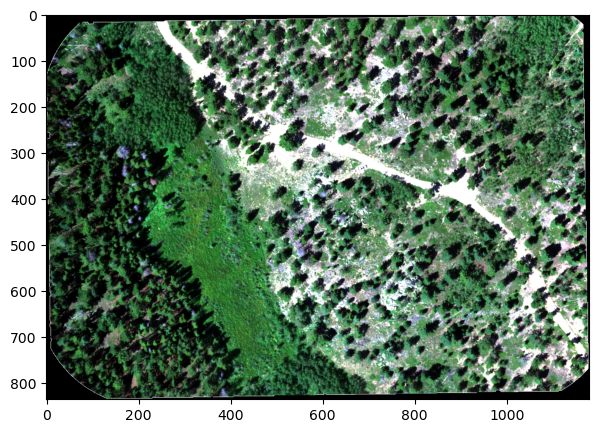

In [28]:
show_rgb(envi, correct= [])

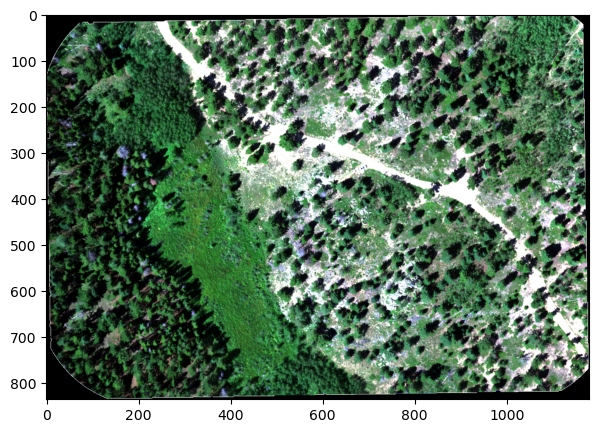

In [29]:
show_rgb(og_envi)

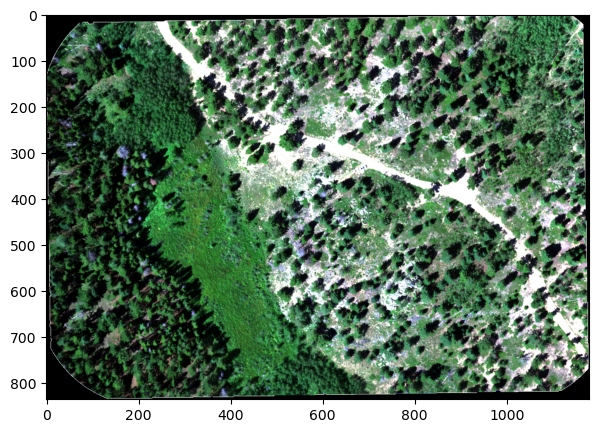

In [30]:
show_rgb(og_envi, correct = ['brdf'])

In [31]:
og_envi.get_wave(862, corrections= ['topo', 'brdf'])

memmap([[-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        ...,
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1],
        [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)

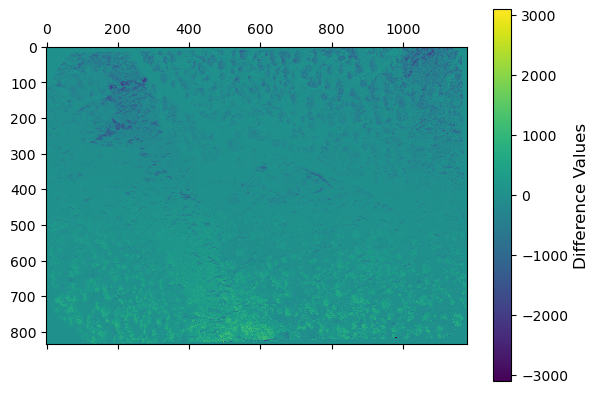

In [32]:
difference = (envi.get_wave(862)) - og_envi.get_wave(862)
plt.matshow(difference, cmap='viridis')  # 'viridis' is the default colormap in Matplotlib

# Add a colorbar to act as a legend for the values
cbar = plt.colorbar()
cbar.set_label('Difference Values', fontsize=12)  # Label for the colorbar

# Show the plot
plt.show()

In [33]:
envi.wavelengths

array([444., 475., 531., 560., 650., 668., 705., 717., 740., 862.])

In [34]:
corrected = envi.get_pixels([100],[300])
corrected


array([[3120.0703],
       [3672.632 ],
       [4627.183 ],
       [5307.4233],
       [6724.493 ],
       [6849.8384],
       [7132.17  ],
       [7412.593 ],
       [7919.3174],
       [8591.958 ]], dtype=float32)

In [35]:
reflectance = corrected.flatten()
reflectance

array([3120.0703, 3672.632 , 4627.183 , 5307.4233, 6724.493 , 6849.8384,
       7132.17  , 7412.593 , 7919.3174, 8591.958 ], dtype=float32)

In [36]:
og_envi2 = og_envi.get_pixels([100],[300])
og_envi2

array([[3192],
       [3713],
       [4766],
       [5447],
       [6877],
       [6997],
       [7258],
       [7509],
       [7996],
       [8617]], dtype=int16)

In [37]:
old_ref = og_envi2.flatten()
old_ref

array([3192, 3713, 4766, 5447, 6877, 6997, 7258, 7509, 7996, 8617],
      dtype=int16)

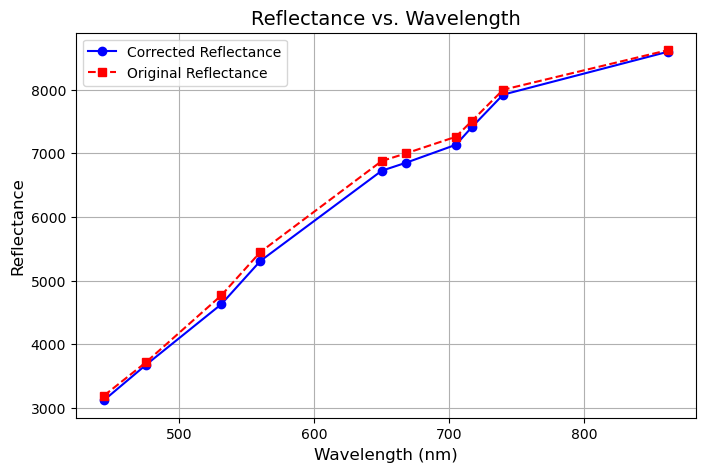

In [40]:
import matplotlib.pyplot as plt

# Create the figure and axes
plt.figure(figsize=(8, 5))  # Set figure size

# Plot both reflectance curves on the same graph
plt.plot(envi.wavelengths, reflectance, marker='o', linestyle='-', color='b', label='Corrected Reflectance')
plt.plot(envi.wavelengths, old_ref, marker='s', linestyle='--', color='r', label='Original Reflectance')

# Labels and title
plt.xlabel("Wavelength (nm)", fontsize=12)
plt.ylabel("Reflectance", fontsize=12)
plt.title("Reflectance vs. Wavelength", fontsize=14)

# Legend and grid
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


# Use the below code to generate files for all dir, only when you are confident that the above code is working

In [43]:
# base_dir = "/home/jovyan/data-store/earthlab/macrosystems/field-data/output"

# # Dictionary mapping package names to their respective datetime strings
# date_time_dict = {
#     "AOP-GORDON-08-14-23-ExportPackage": "2023-08-16 18:53:18",
#     # Add other package datetime mappings here
# }

# # Scripts
# neon2envi_script = "neon2envi2_generic.py"
# image_correction_script = "image_correct.py"

# # Define Wavelengths and Full Width at Half Maximum (FWHM) for spectral bands
# wavelengths = [444, 475, 531, 560, 650, 668, 705, 717, 740, 862]  # In nm
# fwhm = [28, 32, 14, 27, 16, 14, 10, 12, 18, 57]

# # Iterate over all directories (packages) in the base directory
# for package in os.listdir(base_dir):
#     package_path = os.path.join(base_dir, package)
#     if not os.path.isdir(package_path):
#         continue  # Skip files, only process directories
    
#     date_time_str = date_time_dict.get(package, "Unknown Date")
#     if date_time_str == "Unknown Date":
#         print(f"Skipping {package}, no datetime entry found.")
#         continue
    
#     output_dir = package_path
#     file_path = os.path.join(package_path, 'aligned_orthomosaic.tif')
#     slope_path = os.path.join(package_path, 'aligned_slope.tif')
#     aspect_path = os.path.join(package_path, 'aligned_aspect.tif')
#     chm_path = os.path.join(package_path, 'aligned_chm.tif')

#     longitudes, latitudes, cols, rows = drone_utils.pixel_to_coord(file_path)
#     azimuth, zenith = drone_utils.get_computed_azimuth_zenith(file_path, date_time_str, latitudes, longitudes)

#     h5_filepath = drone_utils.tiff_to_h5(file_path, slope_path, aspect_path, chm_path, zenith, azimuth, wavelengths, fwhm, output_dir)
    
#     if not os.path.exists(h5_filepath):
#         print(f"HDF5 file creation failed for {package}")
#         continue
    
#     drone_utils.process_hdf5_with_neon2envi(h5_filepath, neon2envi_script, output_dir)
    
#     neond13_basefilename = drone_utils.get_neon_filename(file_path).replace('.tif', '')
#     neond13_directory = os.path.join(output_dir, neond13_basefilename)
#     config_files = drone_utils.generate_config_files(neond13_directory)
    
#     json_path = os.path.join(neond13_directory, f"{neond13_basefilename}_config__reflectance.json")
#     drone_utils.brdf_topo_correct_image(image_correction_script, json_path)
    
#     geojson_path = '/home/jovyan/data-store/cross-sensor-cal/aop_macrosystems_data_1_7_25.geojson'
#     geojson_path_half = '/home/jovyan/data-store/cross-sensor-cal/aop_polygons_1_24_2025_analysis_ready_half_diam.geojson'
    
#     raster_path = os.path.join(neond13_directory, f"{neond13_basefilename}__reflectance")
#     output_csv = os.path.join(neond13_directory, "NEON_D13_NIWO_reflectance_per_pixel.csv")
    
#     polygons = drone_utils.check_and_reproject(geojson_path, raster_path)
#     drone_utils.extract_pixel_reflectance(geojson_path, raster_path, output_csv)
    
#     print(f"Processing completed for {package}\n")


Band1 has shape (835, 1179)
eastings shape (835, 1179)
HDF5 file created: /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5
Using script: /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py
Executing command: /opt/conda/envs/macrosystems/bin/python /home/jovyan/data-store/cross-sensor-cal/neon2envi2_generic.py -anc --images /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage/NEON_D13_NIWO_test_aligned_orthomosaic.h5 --output_dir /home/jovyan/data-store/earthlab/macrosystems/field-data/output/AOP-GORDON-08-14-23-ExportPackage
2025-01-31 09:24:14,047	WARNING services.py:1996 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm si